<a href="https://colab.research.google.com/github/qlqqqk/Aiffel_prac/blob/main/EXP/%5BE-04%5D/%5BE_04%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files,drive
# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(name=fn,length=len(uploaded[fn])))
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [3]:
data_dir = '/content/drive/MyDrive/Aiffel/data/kaggle_housingData/'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

## 캐글러의 EDA 따라해보기
출처: https://www.kaggle.com/code/chocozzz/house-price-prediction-eda-updated-2019-03-12
#### 상관관계


1.   상관관계
  - 피어슨 상관관계 : 연속형 변수에 사용
       - Pearson 상관은 두 계량형 변수 사이의 선형 관계를 평가합니다. 한 변수의 변화가 다른 변수의 변화에 비례적으로 연관되어 있는 경우 선형 관계가 있습니다.
  - 스피어만 순위 상관관계 : 범주형 변수도 포함되었을 경우에 사용
      - 스피어먼 상관 계수는 순위가 매겨진 변수 간의 피어슨 상관 계수 로 정의된다
2.   데이터 시각화 분석 흐름 요약
  - 2-1. 상관관계를 통해 데이터를 더 자세히 들여다봐야할 feature들을 정립
      - 가격에 큰 영향을 미치는 순서 (등급-주거공간크기-전체크기)
      - 특이사항 발견 : 위도 값과 집 가격의 높은 상관관계(좌표상으로 시애틀 지역의 데이터이며, 지역특성상 북쪽의 집들이 살기좋은 특성이 있다고 함.)
  - 2-2. 목적변수와 해당 feature들의 분포를 보면서 디테일한 관계와 이상치등 정보 수집
  - 2-3. 찾아낸 정보를 기반으로 외부 자료들을 참고 feature 값들의 의미 해석
      - grade의 경우 "1-3은 건물 건축 및 디자인에 미치지 못하고 7은 평균 수준의 건축 및 디자인을, 11-13은 높은 수준의 건축 및 디자인을 지니고 있습니다." 라고 합니다. (필자도 grade에 대한 정보를 구글링해보았으나 찾지 못함.)
      - bathrooms같은경우 소숫점이 있어서 많이 헷갈릴 수 있습니다. 각각의 값이 의미하는것은 아래와 같고 위의 값만을 가지고 각각의 값이 몇개있는지는 구분하기 힘들어 보입니다. (정보의 출처가 궁금한...부분..) 


---

    0.5 : 세면대, 화장실
    0.75 : 세면대, 화장실, 샤워실
    1 : 세면대, 화장실, 샤워실, 욕조

---




['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


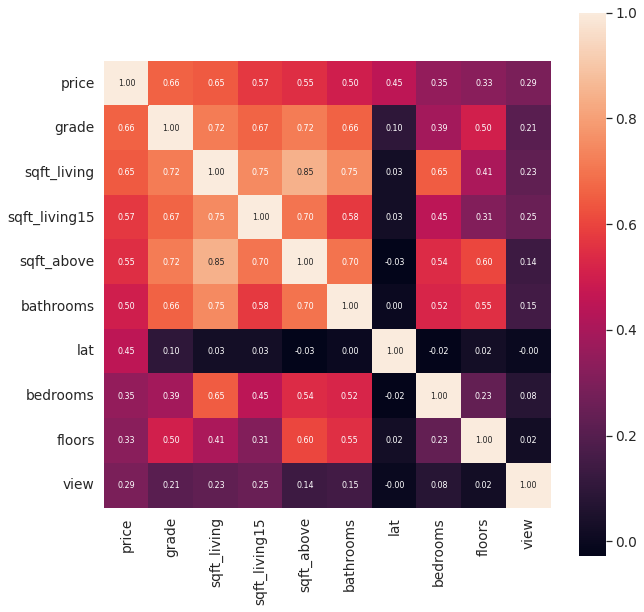

In [4]:
# correlation이 높은 상위 10개의 heatmap
# continuous + sequential variables --> spearman
# abs는 반비례관계도 고려하기 위함
'''아래는 목적변수인 가격과 가장 상관관계가 높은 순서대로 스피어만 순위 상관관계를 본 히트맵입니다.
 전부 보는 것이 아니라 분석의 편의를 위해 상관도가 높은 상위 10개의 값만 보도록 하겠습니다.'''
import scipy as sp

cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

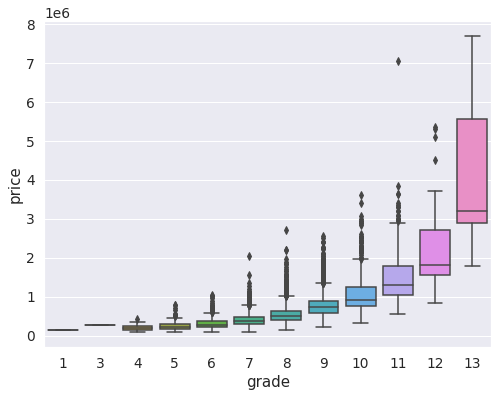

In [5]:
'''등급 3의 경우 값이 큰 이유
등급 7,8,9에서 이상치가 많은 이유
등급 8과 11에서 차이가 큰 이상치가 나타나는 이유에 대해 고민함.'''
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=train)

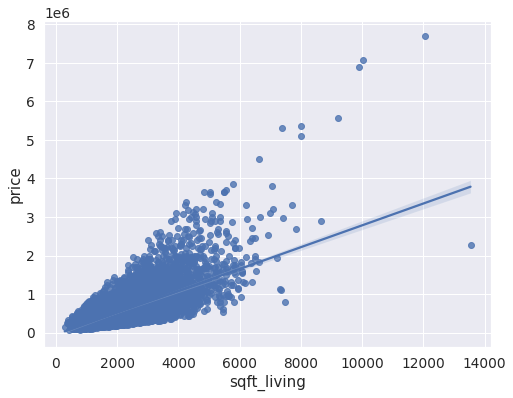

In [6]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=train)

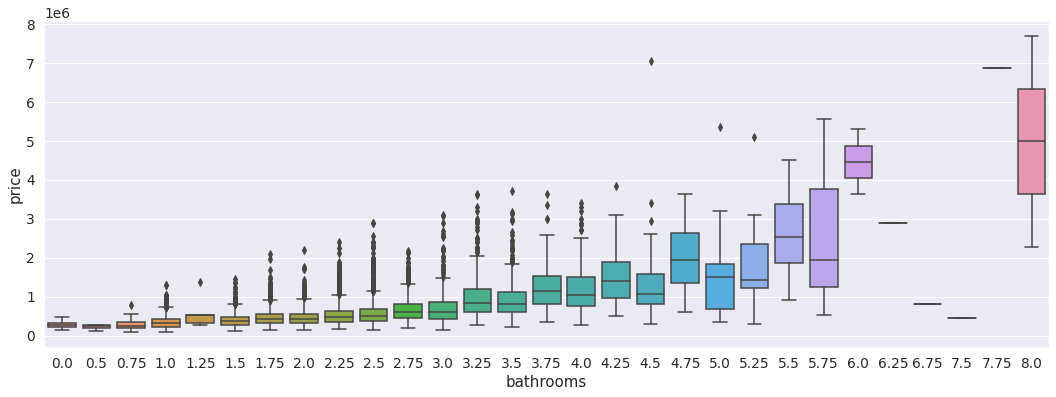

In [7]:
''' 0.5 : 세면대, 화장실
    0.75 : 세면대, 화장실, 샤워실
    1 : 세면대, 화장실, 샤워실, 욕조'''
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bathrooms', y="price", data=train)

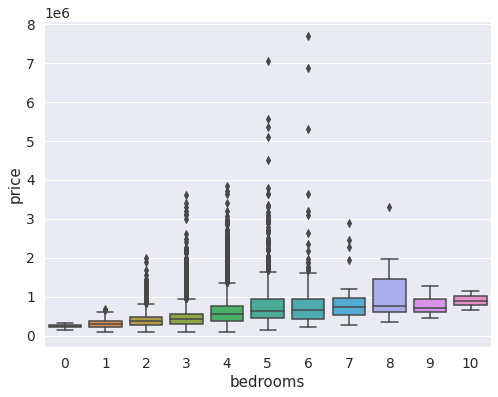

In [8]:
'''약한 양의 상관관계도 맞지만(상관관계를 볼때 median을 기준으로 보는 부분 기억해야할 부분.)
, 방의 개수와 상관없이 가격이 높은 이상치들이 자주 보임 우리나라의 강남과 비교하며 코멘트함.'''
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=train)

In [9]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [10]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [11]:
'''이상치 처리 후 모델학습결과 오히려 점수가 상승해버리는 영향 // 이상치가 모델이 가중치 판단하는 주요한 근거...?'''
# def get_outlier(df=None, column=None, weight=1.5):
#   # target 값과 상관관계가 높은 열을 우선적으로 진행
#   quantile_25 = np.percentile(df[column].values, 25)
#   quantile_75 = np.percentile(df[column].values, 75)

#   IQR = quantile_75 - quantile_25
#   IQR_weight = IQR*weight
  
#   lowest = quantile_25 - IQR_weight
#   highest = quantile_75 + IQR_weight
  
#   outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
#   return outlier_idx

# # 함수 사용해서 이상치 값 삭제
# for col in train.columns:
#   outlier_idx = get_outlier(df=train, column=col, weight=1.5)
#   train.drop(outlier_idx, axis=0, inplace=True)

'이상치 처리 후 모델학습결과 오히려 점수가 상승해버리는 영향 // 이상치가 모델이 가중치 판단하는 주요한 근거...?'

In [12]:
#목적변수 설정
y = train['price']
del train['price']
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [13]:
#test 셋에도 train과 동일한 처리
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [14]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

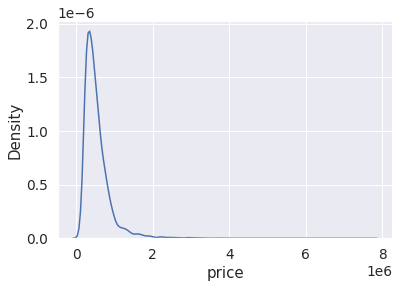

In [15]:
#목적변수의 정규화가 필요함. 이를 log변환을 통해 완화하려함.
sns.kdeplot(y)
plt.show()

In [16]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

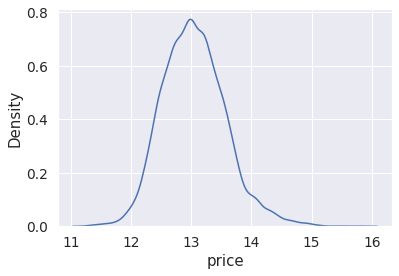

In [17]:
sns.kdeplot(y)
plt.show()

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [19]:
#np.expm1 <<< 로그변환했던 값을 다시 되돌려주는 작업을 반드시 이행해야 함
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [20]:
#랜덤 스테이트는 최대한 고정한 상태에서 파라미터 조정해보려함
random_state=2020         

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [21]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [22]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

[05:56:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'GradientBoostingRegressor': 128360.19649691365,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562,
 'XGBRegressor': 131067.44622809246}

In [23]:
#for문의 함수화 // get_score의 test는 validation set임. 모델이 test data에 과적합 가능성을 없애기 위해 이런 방식으로 진행. 
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df
get_scores(models, train, y)

[05:56:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,RMSE
XGBRegressor,131067.446228
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359


In [24]:
#그리드 서치에서 사용될 파라미터 값들을 따로 변수로 설정
param_grid = {'reg_lambda':[0,1],
    'n_estimators': [200],
    'max_depth': [10,20,30],
    'num_iterations ':[1000,100]
}

In [25]:
model = LGBMRegressor(random_state=random_state)

In [26]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [10, 20, 30], 'n_estimators': [200],
                         'num_iterations ': [1000, 100], 'reg_lambda': [0, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [27]:
#파라미터 경우의 수
params = grid_model.cv_results_['params']
params

[{'max_depth': 10,
  'n_estimators': 200,
  'num_iterations ': 1000,
  'reg_lambda': 0},
 {'max_depth': 10,
  'n_estimators': 200,
  'num_iterations ': 1000,
  'reg_lambda': 1},
 {'max_depth': 10,
  'n_estimators': 200,
  'num_iterations ': 100,
  'reg_lambda': 0},
 {'max_depth': 10,
  'n_estimators': 200,
  'num_iterations ': 100,
  'reg_lambda': 1},
 {'max_depth': 20,
  'n_estimators': 200,
  'num_iterations ': 1000,
  'reg_lambda': 0},
 {'max_depth': 20,
  'n_estimators': 200,
  'num_iterations ': 1000,
  'reg_lambda': 1},
 {'max_depth': 20,
  'n_estimators': 200,
  'num_iterations ': 100,
  'reg_lambda': 0},
 {'max_depth': 20,
  'n_estimators': 200,
  'num_iterations ': 100,
  'reg_lambda': 1},
 {'max_depth': 30,
  'n_estimators': 200,
  'num_iterations ': 1000,
  'reg_lambda': 0},
 {'max_depth': 30,
  'n_estimators': 200,
  'num_iterations ': 1000,
  'reg_lambda': 1},
 {'max_depth': 30,
  'n_estimators': 200,
  'num_iterations ': 100,
  'reg_lambda': 0},
 {'max_depth': 30,
  'n_es

In [28]:
#5Fold를 통해 낸 그리드서치의 점수
score = grid_model.cv_results_['mean_test_score']
score

array([-0.02618845, -0.02613737, -0.02618845, -0.02613737, -0.02624485,
       -0.02604879, -0.02624485, -0.02604879, -0.02624485, -0.02604879,
       -0.02624485, -0.02604879])

In [29]:
results = pd.DataFrame(params)
results['score'] = score
results['RMSE'] = np.sqrt(-1 * results['score'])
results = results.rename(columns={'RMSE': 'RMSLE'})
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,num_iterations,reg_lambda,score,RMSLE
5,20,200,1000,1,-0.026049,0.161396
7,20,200,100,1,-0.026049,0.161396
9,30,200,1000,1,-0.026049,0.161396
11,30,200,100,1,-0.026049,0.161396
1,10,200,1000,1,-0.026137,0.161671
3,10,200,100,1,-0.026137,0.161671
0,10,200,1000,0,-0.026188,0.161828
2,10,200,100,0,-0.026188,0.161828
4,20,200,1000,0,-0.026245,0.162003
6,20,200,100,0,-0.026245,0.162003


In [30]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [31]:
param_grid = {
    'n_estimators': [200],
    'max_depth': [5,10,20],
    'learning_rate':[0.05,0.07,0.1],
    'num_iterations ':[1000,100] 
}

model1 = LGBMRegressor(random_state=random_state)
my_GridSearch(model1, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,learning_rate,max_depth,n_estimators,num_iterations,score,RMSLE
15,0.10,10,200,100,-0.026188,0.161828
14,0.10,10,200,1000,-0.026188,0.161828
17,0.10,20,200,100,-0.026245,0.162003
16,0.10,20,200,1000,-0.026245,0.162003
11,0.07,20,200,100,-0.026384,0.162432
10,0.07,20,200,1000,-0.026384,0.162432
9,0.07,10,200,100,-0.026507,0.162809
8,0.07,10,200,1000,-0.026507,0.162809
3,0.05,10,200,100,-0.026848,0.163852
2,0.05,10,200,1000,-0.026848,0.163852


In [32]:
model1 = LGBMRegressor(max_depth=10, n_estimators=200,num_iterations=1000, random_state=random_state)
model1.fit(train, y)
prediction = model1.predict(test)
prediction = np.expm1(prediction)
prediction

array([ 537642.88051594,  498186.08760612, 1225585.45639546, ...,
        465932.667101  ,  334778.91334668,  443790.13608839])

In [33]:
param_grid = {
    'n_estimators': [200],
    'max_depth': [5,10,20],
    'eta ':[0.05,0.1,0.2],
    'sub_sample':[0.5,1]
}

model2 = XGBRegressor(random_state=random_state)
my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[06:08:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,eta,max_depth,n_estimators,sub_sample,score,RMSLE
8,0.10,10,200,0.5,-0.026859,0.163887
15,0.20,10,200,1.0,-0.026859,0.163887
2,0.05,10,200,0.5,-0.026859,0.163887
3,0.05,10,200,1.0,-0.026859,0.163887
14,0.20,10,200,0.5,-0.026859,0.163887
9,0.10,10,200,1.0,-0.026859,0.163887
13,0.20,5,200,1.0,-0.027009,0.164345
12,0.20,5,200,0.5,-0.027009,0.164345
0,0.05,5,200,0.5,-0.027009,0.164345
7,0.10,5,200,1.0,-0.027009,0.164345


In [40]:
model2 = XGBRegressor(max_depth=10, n_estimators=200,eta=0.05 ,random_state=random_state)
model2.fit(train, y)
prediction2 = model2.predict(test)
prediction2 = np.expm1(prediction2)
prediction2

[06:21:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([ 518555.34,  401180.12, 1255738.  , ...,  480947.34,  344189.3 ,
        445271.66], dtype=float32)

In [35]:
param_grid = {
    'n_estimators': [100,200,500],
    'max_depth': [3,10,20],
}

model3 = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


,max_depth,n_estimators,score,RMSLE
2,3,500,-0.027518,0.165885
4,10,200,-0.029427,0.171544
3,10,100,-0.029483,0.171707
5,10,500,-0.029487,0.171718
1,3,200,-0.029817,0.172677
0,3,100,-0.033394,0.182741
6,20,100,-0.052130,0.228320
8,20,500,-0.052130,0.228320
7,20,200,-0.052130,0.228320


In [36]:
model3 = GradientBoostingRegressor(max_depth=3, n_estimators=200, random_state=random_state)
model3.fit(train, y)
prediction3 = model3.predict(test)
prediction3 = np.expm1(prediction3)
prediction3

array([ 537091.9444577 ,  385761.06496418, 1293275.79615907, ...,
        437181.91788569,  336457.76079361,  421081.83041776])

In [37]:
data_dir ='/content/drive/MyDrive/Aiffel/data/kaggle_housingData/'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [38]:
submission['price'] = 0.6*prediction + 0.4*prediction2
submission.head()

,id,price
0,15035,5.300079e+05
1,15036,4.593837e+05
2,15037,1.237646e+06
3,15038,2.981050e+05
4,15039,3.297004e+05


In [39]:
submission_csv_path = '{}/submission.csv'.format(data_dir)
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/content/drive/MyDrive/Aiffel/data/kaggle_housingData//submission.csv
